In [2]:
%matplotlib inline
from IPython.core.pylabtools import figsize

import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

import pymc as pm

import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import multivariate_normal

figsize(11, 9)

# Lecture 10: Bayesian Methods

This lecture is going to be about Bayesian Methods for inference and we reference this free book called [Probabilistic Programming & Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/):
![](http://i.imgur.com/6DKYbPb.png)

This is a huge area onto itself and we can easily devote an entire course to it so this single lecture cannot possible do any justice to it, but hopefully we will give you some intuitions about these methods.

## The Bayesian Weltanschauung

The Bayesian world-view interprets probability as measure of *believability* in an event, that is, how confident we are in an event occurring. *Frequentist*, known as the more classical version of statistics, assume that probability is the long-run frequency of events, e.g. the probability of plane accidents under a frequentist philosophy is interpreted as the long-term frequency of plane accidents. Though this makes logical sense for many probabilities of events, it is difficult to understand when events have no long-term frequency of occurrences. We often assign probabilities to outcomes of presidential elections, but the election itself only happens once!  Frequentists get around this by invoking alternative realities and saying across all these realities, the frequency of occurrences defines the probability.

Bayesians, on the other hand, have a more intuitive approach. Bayesians interpret a probability as measure of *belief*, or confidence, of an event occurring.  Simply, a probability is a summary of an opinion.  A belief of 0 means no confidence that the event will occur; and 1 implies that it is absolutely certain it will. This agrees with the plane crash example and it is meaningful to talk about the probabilities (belief) of  presidential election outcomes. Treating belief  as probability is natural to humans where as you have to be trained to think like a frequentist.

> When the facts change, I change my mind. What do you do, sir?
> -- John Maynard Keynes

This quote reflects the way a Bayesian updates their belief after seeing evidence or data. We denote our updated belief as $P(H|D)$. We call the updated belief the posterior probability so as to contrast it with the prior  $P(H)$. By introducing prior uncertainty about events, we are already admitting that any guess we make is potentially very wrong. After observing data, evidence, or other information, we update our beliefs, and our guess becomes less wrong.

## Bayesian Inference

If frequentist and Bayesian inference were programming functions with inputs being statistical problems, then the  frequentist inference function would return a number (some summary statistic like average) whereas the Bayesian function would return *probabilities*. And the Bayesian function will also have an additional parameter to include our belief about the question. 

As we acquire more and more instances of evidence, our prior belief is washed out by the new evidence. As we get more and more data  our Bayesian results (often) align with frequentist results. On the other hand, for smaller number of evidence frequentist estimates have more variance and larger confidence intervals. This is where Bayesian analysis excels. By introducing a prior, and returning probabilities we preserve the uncertainty that reflects the instability of frequentist estimates.

> $N$ is never enough because if it were "enough" you'd already be on to the next problem for which you need more data. 
> -- Andrew Gelman

Updating our belief is done via Bayes' Theorem:
$$
P(H|D) = \frac{P(D|H) P(H)}{P(D)} \propto P(D|H) P(H)
$$

## Bayesian Modeling

The process of Bayesian data modeling can be idealised by dividing it into the  following three steps:
1.  Setting up a full probability model: a joint probability distribution for all observable and unobservable quantities in a problem
2. Conditioning on observed data: calculating and interpreting the appropriate posterior distribution which is  the conditional probability distribution of the unobserved quantities of interest given the observed data
3. Evaluating the fit of the model and implications of the resulting posterior

## Conjugate Prior Relationships
If the  posterior distributions are in the same family as the prior the prior is called a *conjugate prior*.  
![](http://www.johndcook.com/conjugate_prior_diagram.gif)

This [diagram](http://www.johndcook.com/conjugate_prior_diagram.html)  shows the relationships for a number of common sampling distributions. For example if the sampling distribution for $x$ is Binomial the posterior is Beta etc. The Gaussian family is conjugate to itself. A conjuggate proir is an an algebraic convenience, giving a closed-form expression for the posterior: otherwise a difficult numerical integration may be necessary (in which case we need methods like Monte Carlo which are in the second part of this lecture).

## Coin-Flip Example

Suppose, naively, that you are unsure about the probability of heads in a coin flip. You believe there is some true underlying ratio, call it $p$, but have no prior opinion on what $p$ might be. We can plot a sequence of updating posterior probabilities as we observe increasing amounts of data:

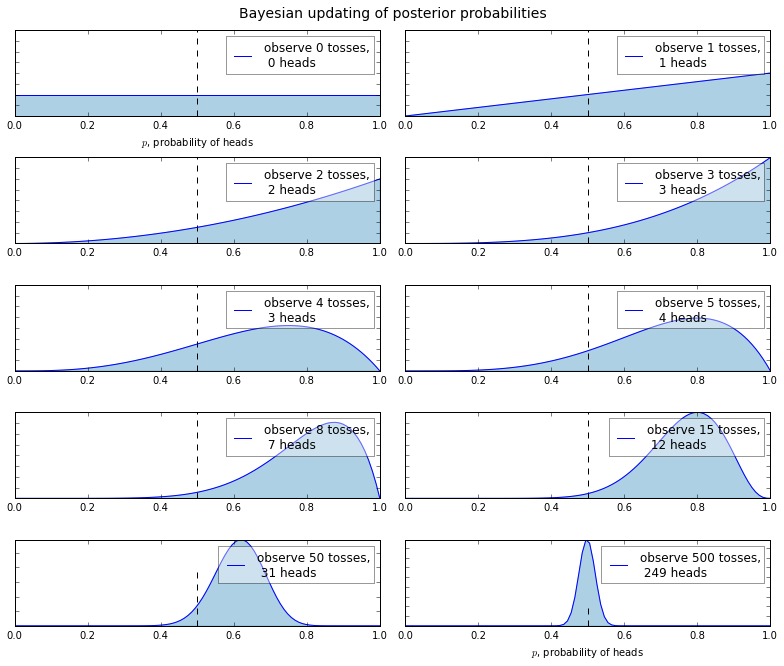

In [3]:
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = stats.bernoulli.rvs(0.5, size=n_trials[-1])
x = np.linspace(0, 1, 100)

# Using Binomial's conjugate prior which is beta.
dist = stats.beta
for k, N in enumerate(n_trials):
    sx = plt.subplot(len(n_trials) / 2, 2, k + 1)
    plt.xlabel("$p$, probability of heads") \
        if k in [0, len(n_trials) - 1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:N].sum()
    y = dist.pdf(x, 1 + heads, 1 + N - heads)
    plt.plot(x, y, label="observe %d tosses,\n %d heads" % (N, heads))
    plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)

    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)

plt.suptitle("Bayesian updating of posterior probabilities",
             y=1.02,
             fontsize=14)

plt.tight_layout()

## Bayesian Formulation of Regression

For an arbitrary prior distribution, there may be no analytical solution for the posterior distribution. Here we will consider a conjugate prior for which the  posterior distribution can be derived analytically. 

In the linear regression model we have data  of $n$ observations  given by:
$$\left\{ ({\bf x}_1, y_1), ({\bf x}_2,y_2), \ldots, ({\bf x}_n, y_n) \right\} $$
where ${\bf x}$  denotes an input vector of dimension $p$ and $y_i$ denotes a scalar output (dependent variable). All data points are combined into a $p \times n$ matrix $X$. The model that determines the relationship between inputs and  output is given by:
$$ {\bf y}   = X^{T} \bf{\beta} + \epsilon $$
where ${\bf \beta}$ is a vector of parameters of the linear model.  Usually there a bias or offset is included, but for now we ignore it.

We assume that the additive noise  $\epsilon$ is iid Gaussian with zero mean and variance $\sigma_n^2$  and $ \epsilon \sim {\cal N}(0, \sigma^2_n)$. Another way of saying this is that the density of $\epsilon$ is given by:
$$
p(\epsilon) =  \frac{1}{\sqrt{2\pi}\sigma_n} \exp{\left( -\frac{\epsilon^2 }{2\sigma_n^2} \right)}.
$$

This then implies that the likelihood is the product (since we assume independence):
\begin{eqnarray*}
L &=& p({\bf y}| X,{\bf \beta}) = \prod_{i=1}^{n} p(y_i| X_i, {\bf \beta}) = \frac{1}{\sqrt{2\pi}\sigma_n}  \prod_{i=1}^{n}
   \exp{ \left( -\frac{(y_i- X_i^T {\bf \beta})^2}{2\sigma_n^2} \right)} \\
   &=& \frac{1}{\sqrt{2\pi}\sigma_n} \exp{\left( -\frac{| {\bf y}-X^T {\bf \beta}|^2 }{2\sigma_n^2} \right)} = {\cal N}(X^T {\bf \beta},  \sigma_n^2 I).
\end{eqnarray*}

An alternative way of expressing the likelihood, which is convenient when sampling ${\bf \beta}$'s is:
$$
p({\bf y}| X,{\bf \beta}) = \frac{1}{\sqrt{2\pi}\sigma_n} \exp{\left( -\frac{| X^{-1} {\bf y} - {\bf \beta}|^2 \,\, (X^{-1} (X^{-1})^{T}) }{2\sigma_n^2} \right)} = {\cal N}(X^{-1} {\bf y},  \sigma_n^2 (X^{-1} (X^{-1})^{T}) ).
$$

In the Bayesian framework inference we need to specify a prior over the parameters that expresses our belief about the parameters
before we take any measurements. A wise choice is a zero mean  Gaussian with covariance matrix $\Sigma$:
$$  \beta \sim {\cal N}(0, \Sigma).$$
We can now continue with the standard Bayesian formalism:
\begin{eqnarray*}
 p({\bf \beta}| {\bf y},X) &\propto& p({\bf y} | X, {\bf \beta}) \, p({\bf \beta})  \\
      &\propto& \exp{ \left(- \frac{1}{2 \sigma_n^2}({\bf y}-X^T {\bf \beta})^T({\bf y} - X^T {\bf \beta}) \right)}
                        \exp{\left( -\frac{1}{2} {\bf \beta}^T \Sigma^{-1} {\bf \beta} \right)}.
\end{eqnarray*}
Next we "complete the square" and get:
$$
p({\bf \beta}| {\bf y},X)  \propto  \exp \left( -\frac{1}{2} ({\bf \beta}- \bar{{\bf \beta}})^T  (\frac{1}{\sigma_n^2} X X^T + \Sigma^{-1})({\bf \beta} - \bar{{\bf \beta}} )  \right)
$$
where $\bar{{\bf \beta}} = \sigma_n^{-2}( \sigma_n^{-2}XX^T +\Sigma^{-1})^{-1} X {\bf y} $. This looks like a Gaussian and therefore the posterior is:

$$ p({\bf \beta}| X, {\bf y}) \sim {\cal N}( \frac{1}{\sigma_n^2} A^{-1}Xy , A^{-1} ) $$
where $A= \sigma_n^{-2}XX^T +\Sigma^{-1}$.

To make predictions for a test case we average over all possible parameter predictive distribution values, weighted by their posterior probability. This is in contrast to non Bayesian schemes, where a single parameter is typically chosen by some criterion.

Thus the predictive distribution at some $x^{*}$ is given by averaging the output of all possible linear models w.r.t. the  posterior:
\begin{eqnarray*}
p(y^{*} | x^{*}, X,{\bf y}) &=& \int p({y}^{*}| {x}^{*}, {\bf \beta} ) p({\bf \beta}| X, {\bf y})\, \rm{d} \beta \\
&=& {\cal N} \left(\frac{1}{\sigma_n^2} x^{*^{T}} A^{-1} X {\bf y}, x^{*^T}A^{-1}x^{*} \right),
\end{eqnarray*}
which is again Gaussian, with a mean given by the posterior mean multiplied by the test input and the variance  a quadratic form of the test input with the posterior covariance matrix, showing that the predictive uncertainties grow with the magnitude of the test input, as one would expect for a linear model.

### Linear Regression

Let us model linear regression by updating our knowledge of the parameter $\beta$ as new information or measurements come in. We will first create a ground truth function and generate data with noise:

In [ ]:
a0=-0.3
a1=0.5
N=20
noiseSD=0.2
priorPrecision=2.0
u=np.random.rand(20)
x=2.*u -1.
def randnms(mu, sigma, n):
    return sigma*np.random.randn(n) + mu
y=a0+a1*x+randnms(0.,noiseSD,N)
plt.scatter(x,y)

Next we initialise our prior. Initially we know nothing so we set it to a Gaussian centered at 0.

In [ ]:
likelihoodSD = noiseSD # Assume the likelihood precision, beta, is known.
likelihoodPrecision = 1./(likelihoodSD*likelihoodSD)

def cplot(f):
    plt.figure()
    xx,yy=np.mgrid[-1:1:.01,-1:1:.01]
    pos = np.empty(xx.shape + (2,))
    pos[:, :, 0] = xx
    pos[:, :, 1] = yy
    ax=plt.contourf(xx, yy, f(pos))
    #data = [x, y]
    return ax

priorMean = np.zeros(2)
priorSigma = np.eye(2)/priorPrecision #Covariance Matrix
priorPDF = lambda w: multivariate_normal.pdf(w,priorMean,priorSigma)
priorPDF([1,2])

In [ ]:
np.transpose(priorMean)

In [ ]:
cplot(priorPDF)

In [ ]:
def plotSampleLines(mu, sigma, numberOfLines, dataPoints=None):
    #Plot the specified number of lines of the form y = beta_0 + beta_1*x in [-1,1]x[-1,1] by
    # drawing beta_0, beta_1 from a bivariate normal distribution with specified values
    # for mu = mean and sigma = covariance Matrix. Also plot the data points as
    # blue circles. 
    #print "datap",dataPoints
    fig=plt.figure()

    for i in range(numberOfLines):
        beta = np.random.multivariate_normal(mu,sigma)
        func = lambda x: beta[0] + beta[1]*x
        xx=np.array([-1,1])
        plt.plot(xx,func(xx),'r')
    if dataPoints:
        plt.scatter(dataPoints[0],dataPoints[1])
    ax=plt.gca()
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    plt.show()

In [ ]:
plotSampleLines(priorMean,priorSigma,6)

In [ ]:
# Given the mean = priorMu and covarianceMatrix = priorSigma of a prior
# Gaussian distribution over regression parameters; observed data, xtrain
# and ytrain; and the likelihood precision, generate the posterior
# distribution, postBeta via Bayesian updating and return the updated values
# for mu and sigma. xtrain is a design matrix whose first column is the all
# ones vector.
def update(x,y,likelihoodPrecision,priorMu,priorSigma): 
    postSigmaInv  = np.linalg.inv(priorSigma) + likelihoodPrecision*np.outer(x.T,x)
    postSigma = np.linalg.inv(postSigmaInv)
    postMu = np.dot(np.dot(postSigma,np.linalg.inv(priorSigma)),priorMu) + likelihoodPrecision*np.dot(postSigma,np.outer(x.T,y)).flatten()
    postBeta = lambda beta: multivariate_normal.pdf(beta,postMu,postSigma)
    return postBeta,postMu,postSigma

In [ ]:
# For each iteration plot  the
# posterior over the first i data points and sample lines whose
# parameters are drawn from the corresponding posterior. 
mu = priorMean
sigma = priorSigma
iterations=2
muhash={}
sigmahash={}
for i in range(1,20):
    postBeta,mu,sigma = update(np.array([1,x[i]]),y[i],likelihoodPrecision,mu,sigma)
    muhash[i]=mu
    sigmahash[i]=sigma
    if i in [1,4,7,10,19]:
        cplot(postBeta)

In [ ]:
for i in  range(1,20):
    if i in [1,4,7,10,20]:
        plotSampleLines(muhash[i],sigmahash[i],6, (x[0:i],y[0:i]))

---

# MCMC: Markov Chain Monte Carlo

The aim of Monte Carlo methods is to solve one or both of the following problems:
1. generate samples from a given possibly very complicated and high dimensional probability distribution
2. estimate various characteristics of a distribution such as the mean, variance, kurtosis, or any other statistic

This probability distribution which is called the Target Density might be a distribution from statistical physics or a conditional distribution arising in data modeling: e.g. the posterior. If we solve the first problem then we can solve the second one by using the  random samples to estimate the statistics of interest.

One important property of Monte Carlo is that the accuracy of the MC estimates is independent of the dimensionality of the space sampled. High dimensionality causes other issues for MC: obtaining independent samples from a given distribution becomes hard.

In fact it was this idea of selecting a statistical sample to approximate a hard problem by a simpler one that is at the heart of Monte Carlo methods. Developed by Ulam, it was the reason for the development of the Von Neumann computers to solve problems when developing the Atomic bomb. Over time Ulam,  Von Neumann and others developed many Monte Carlo methods and the rest is history!

## Principle

The idea of Monte Carlo is to draw an iid set of samples from a target density.  These samples can be used to approximate the target density. Consequently one can approximate the integral (or large sum) of a function over the space where the target density is defined. The advantage of Monte Carlo over deterministic integration arises from the fact that the Monte Carlo positions the integration grid (samples) in regions of high probability. When the target density has a standard form e.g. Gaussian it is straight forward to sample from it. When this is not the case, then we need more sophisticated techniques.

### Rejection Sampling

The idea is to sample from a distribution $p(x)$ which is known up to a proportionality constant, by sampling from another easy to sample proposal distribution $q(x)$ that satisfies: $p(x) \le M q(x)$ where $M<\infty $ using the accept/reject procedure:
* Set $i=1$
* Repeat until $i=N$:
  1. sample $x^{(i)}$ from  $q(x)$ and $u$ random variable from $(0,1)$
  2. if $u < p(x^{(i)})/(M q(x^{(i)}))$ then accept $x^{(i)}$ and increment $i$, else reject

This method has severe limitations: it is not always possible to bound $p(x)/q(x)$ over the whole space and if $M$ is too large the probablity of acceptance will be too small, making this impractical for high-dimensional scenarios.

### Importance Sampling

Importance sampling is a general technique for estimating properties of a particular distribution, while only having samples generated from a different distribution rather than the distribution of interest.

So suppose we wish to estimate the expected value of $x$ under $p$ and have $N$ samples from $p$. The basic idea of importance sampling is to change the  probability measure $p$ so that the estimate is easier. Again in higher dimensions it is often impossible to obtain proposal distributions that are easy to sample from  and offers good approximations at the same time. For this reason we need more sophisticated methods like those based on Markov Chains.

## MCMC

MCMC is a strategy for generating samples while exploring the state space using a Markov Chain mechanism. This mechanism is constructed so that the chain spends more time in the most important regions. In particular it is constructed so that the samples $x^{(i)}$ mimic samples from the target distribution. Again we repeat: that we use MCMC when we cannot draw samples from the the target distribution directly but can evaluate $p(x)$  up to a normalising constant.

Markov Chains on a finite state space look like state diagrams and is defined by its current state together with some fixed transition matrix. The idea is that no matter what initial state we choose the chain will stablise after a certain number of iterating over the state space and the transition matrix. This stability result plays an important role  in MCMC simulations. For any starting point the chain will converge to the invariant distribution $p(x)$ as long as the transition matrix is irreducible and aperiodic.

<img src="http://guizzetti.ca/blog/wp-content/uploads/2012/04/3state_markov.jpg" width="400"/>

Usually it is not hard to construct a Markov chain with the desired properties. The more difficult problem is to determine how many steps are needed to converge to the stationary distribution within an acceptable error. A good chain will have rapid mixing i.e.  stationary distribution is reached quickly starting from an arbitrary position.

###  Metropolis-Hastings

The MH algorithm is the most popular of the MCMC methods.  As a matter of fact we will see that most MCMC algorithms can be interpreted as special cases of this algorithm.

Suppose our goal is to sample from the target density $p(x)$, with $-\infty< x < \infty$ . The Metropolis-Hastings sampler creates a Markov chain that produces a sequence of values:
$$ x^{(1)} \rightarrow  x^{(2)}  \rightarrow \ldots  \rightarrow  x^{(t)} \ldots $$
where $x^{(t)}$  represents the state of a Markov chain at iteration $t$. The samples from the chain, after stablising, reflect samples from the target distribution $p(x)$.

The MH algorithm, initializes the first state, $x^{(1)}$  to some initial value, and then uses a proposal distribution $q(x_s|x_t)$ to sample a candidate value $x_s$ given the current value of $x_t$ according to $q(x_s|x_t)$. The Markov chain  then moves towards $x_s$ with the acceptance probability
$$
A(x_t,x_s) = \min\left[1, \frac{p(x_s) \, q(x_t|x_s)}{p(x_t) q(x_s|x_t) } \right]
$$
otherwise it remains at $x_t$.

### Metropolis Algorithm

Note that if the transition probability is symmetric $q(x_s|x^{(i)}) = q(x^{(i)}|x_s)$ then the acceptance probability becomes
$$ A(x,x_s) = \min\left[1, \frac{p(x_s)}{p(x) } \right] $$
which was the original algorithm proposed by Metropolis, thus the Metropolis algorithm.

A major advantage of the MH sampler is that equation involves only a ratio of densities. Therefore, any terms independent of $x$ in the functional form of $p(x)$ will drop out. We do not need to know the normalizing constant of the density or probability.  The fact that this procedure allows us to sample from unnormalized distributions is one of its major attractions. Sampling from unnormalized distributions frequently happens in Bayesian models, where calculating the normalization constant is difficult or impractical.


The MH algorithm is very simple, but it requires careful design of the proposal distribution  $q(x_s| x)$.

In fact many MCMC algorithms arise by considering specific choices of this distribution. A way to design these sampling mechanism is to ensure that detailed balance (a condition on the Markov Chain) is satisfied. However, it is also important to design samplers that converge quickly or where the stabilisation time is short.

### Algorithm to perform MCMC

In general these algorithms can be expressed at a high level as follows. Suppose we should explore the deformed  posterior space generated by our prior surface and observed data to find the posterior mountain. What hope do we have to find these hidden mountains?
We can do a smart search as follows:
1. Start at current position.
2. Propose moving to a new position (investigate a pebble near you).
3. Accept/Reject the new position based on the position's adherence to the data and prior distributions (ask if the pebble likely came from the mountain).
4. Decide:
  * If you accept: Move to the new position. Return to Step 1.
  * Else: Do not move to new position. Return to Step 1.
5. After a large number of iterations, return all accepted positions.

This way we move in the general direction towards the regions where the posterior distributions exist, and collect samples sparingly on the journey. Once we reach 
the posterior distribution, we can easily collect samples as they likely all belong to the posterior distribution.

If the current position of the MCMC algorithm is in an area of extremely low probability, which is often the case when the algorithm begins the algorithm will move in positions that are likely not from the posterior but better than everything else nearby. Thus the first moves of the algorithm are not reflective of the posterior.

### Unsupervised Clustering using a Mixture Model

Another example now, suppose we are given the following dataset:

In [ ]:
data = np.loadtxt("../data/mixture_data.csv", delimiter=",")

figsize(12.5, 4)
plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None])
print data[:10], "..."

What does the data suggest? It appears the data has a bimodal form, that is, it appears to have two peaks, one near 120 and the other near 200. Perhaps there are two clusters within this dataset. This dataset is a good example of the data-generation modeling technique. We can propose how the data might have been created:

1. For each data point indexed by $i$, choose cluster 1 with probability $p$ else choose cluster 2
2. Draw a random variate from a Normal distribution with parameters $\mu_i$ and $\sigma_i$ where $i$ was chosen in step 1
3. Repeat

This algorithm would create a similar effect as the observed dataset, so we choose this as our model. Of course, we do not know $p$ or the parameters of the Normal distributions. Hence we must infer, or learn, these unknowns. Denote the Normal distributions `nor_0` and `nor_1`. Both currently have unknown mean and standard deviation, denoted by $\mu_i$ and $\sigma_i$ for $i=0,1$. A specific data point can be from either  `nor_0` or  `nor_1` and we  assume that the data point is assigned to `nor_0` with probability $p$.

An appropriate way to assign data points to clusters is to use a `pymc.Categorical` stochastic variable.  Its parameter is a $k$-length  array of probabilities that must sum to one and its `value`  attribute is a integer between 0 and $k-1$ randomly randomly chosen according to the crafted array of probabilities. Apriori we do not know what the probability of assignment to cluster 1 is, so we create a uniform variable over 0,1 to model this. We call this `p`. Thus the probability array we enter into the `Categorical` variable is `[p,1-p]`:

In [ ]:
p = pm.Uniform("p", 0, 1)

assignment = pm.Categorical("assignment", [p, 1 - p], size=data.shape[0])
print "prior assignment, with p = %.2f:" % p.value
print assignment.value[:10], "..."

Looking at the above dataset, I would guess that the standard deviations of the two Normals are different. To maintain ignorance of what the standard deviations might be, we will initially model them as uniform on 0 to 100. Really we are talking about $\tau = 1/\sigma^2$ of the  Normal distribution, but it is easier to think in terms of standard deviation.  Our PyMC code will need to transform our standard deviation into precision. In PyMC, we can do this in one step by writing:

In [ ]:
taus = 1.0 / pm.Uniform("stds", 0, 100, size=2) ** 2

Notice that we specified `size=2`: we are modeling both $\tau$'s as a single PyMC variable. Note that this does not induce a necessary relationship between the two $\tau$'s, it is simply for succinctness.

We now need to specify priors on the centers of the clusters. The centers are really the $\mu$ parameters in this Normal distributions. Their priors can be modeled by a Normal distribution. Looking at the data, we can guess that the centers might be somewhere around 120 and 190 respectively and $\sigma_i = 10$ for both. We set these in these in the `center` and note we convert to $\tau = 1/10^2$:

In [ ]:
centers = pm.Normal("centers", [120, 190], [0.01, 0.01], size=2)

"""
The below deterministic functions map an assignment, in this case 0 or 1,
to a set of parameters, located in the (1,2) arrays `taus` and `centers`.
"""

@pm.deterministic
def center_i(assignment=assignment, centers=centers):
    return centers[assignment]

@pm.deterministic
def tau_i(assignment=assignment, taus=taus):
    return taus[assignment]

print "Random assignments: ", assignment.value[:4], "..."
print "Assigned center: ", center_i.value[:4], "..."
print "Assigned precision: ", tau_i.value[:4], "..."

In [ ]:
# and to combine it with the observations:
observations = pm.Normal("obs", center_i, tau_i, value=data, observed=True)

# below we create a model class
model = pm.Model([p, assignment, taus, centers])

PyMC has an MCMC class, `MCMC` in the main namespace of PyMC, that implements the MCMC exploring algorithm. We initialize it by passing in a `Model` instance:

In [ ]:
mcmc = pm.MCMC(model)

The method for asking the `MCMC` to explore the space is `sample( iterations )`, where iterations is the number of steps you wish the algorithm to perform. We try 50000 steps below:

In [ ]:
mcmc.sample(50000)

We plot the  paths, or "traces", the unknown parameters (centers, precisions, and $p$) have taken thus far. The traces can be retrieved using the `trace` method in the `MCMC` object created, which accepts the assigned PyMC variable name. For example, `mcmc.trace("centers")` will retrieve a `Trace` object that can be indexed (using `[:]` or `.gettrace()` to retrieve all traces, or fancy-indexing like `[1000:]`):

In [ ]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = mcmc.trace("centers")[:]

colors = ["#348ABD", "#A60628"]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = mcmc.trace("stds")[:]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = mcmc.trace("p")[:]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color="#467821", lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend()

Notice the following characteristics:
1. The traces converges, not to a single point, but to a distribution of possible points. This is convergence in an MCMC algorithm.
2. Inference using the first few thousand points is a bad idea, as they are unrelated to the final distribution we are interested in. Thus is it a good idea to discard those samples before using the samples for inference. We call this period before converge the burn-in period.
3. The traces appear as a random "walk" around the space, that is, the paths exhibit correlation with previous positions. This is both good and bad. We will always have correlation between current positions and the previous positions, but too much of it means we are not exploring the space well.

To achieve further convergence, we can perform more MCMC steps since the `value` attribute is not overwritten. Thus it is fine to halt an MCMC algorithm and inspect its progress, with the intention of starting it up again later.

So let us now come to our main challenge: identify the clusters. We have determined posterior distributions for our unknowns. We plot the posterior distributions of the center and standard deviation variables below:

In [ ]:
figsize(11.0, 4)
std_trace = mcmc.trace("stds")[:]

_i = [1, 2, 3, 0]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()

The MCMC algorithm has proposed that the most likely centers of the two clusters are near 120 and 200 respectively. Similar inference can be applied to the standard deviation.

We are also given the posterior distributions for the labels of the data point, which is present in `mcmc.trace("assignment")`. Below is a visualization of this. The y-axis represents a subsample of the posterior labels for each data point. The x-axis are the sorted values of the data points. A blue square is an assignment to cluster 1, and a red square is an assignment to cluster 0:

In [ ]:
figsize(12.5, 4.5)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(mcmc.trace("assignment")[::400, np.argsort(data)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points")

Looking at the above plot, it appears that the most uncertainty is between 150 and 170. The above plot slightly misrepresents things, as the x-axis is not a true scale (it displays the value of the ith sorted data point.) A more clear diagram is below, where we have estimated the frequency of each data point belonging to the labels 0 and 1.

In [ ]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = mcmc.trace("assignment")[:]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point")

Even though we modeled the clusters using Normal distributions, we didn't get just a single Normal distribution that best fits the data (whatever our definition of best is), but a distribution of values for the Normal's parameters. How can we choose just a single pair of values for the mean and variance and determine a sorta-best-fit gaussian?

One quick and dirty way is to use the mean of the posterior distributions. Below we overlay the Normal density functions, using the mean of the posterior distributions as the chosen parameters, with our observed data:

In [ ]:
norm = stats.norm
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = mcmc.trace("p")[:].mean()

plt.hist(data, bins=20, histtype="step", normed=True, color="k",
     lw=2, label="histogram of data")
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters")

What about prediction? Suppose we observe a new data point, say  $x=175$ and we wish to label it to a cluster. It is foolish to simply assign it to the closer cluster center, as this ignores the standard deviation of the clusters, and we have seen from the plots above that this consideration is very important. More formally: we are interested in the probability   of assigning $x=175$ to cluster 1. Denote the assignment of $x$ the assignment of $x$ as $L_x$, which is equal to 0 or 1, and we are interested in $P(L_x = 1 \;|\; x = 175 )$. 

A naive method to compute this is to re-run the above MCMC with the additional data point appended. The disadvantage with this method is that it will be slow to infer for each novel data point. Alternatively, we can try a less precise, but much quicker method: Bayes Theorem. In our case the $H$ is $L_x=1$ and $D$ is the evidence we have:  we observe that $x=175$. For a particular sample set of parameters for our posterior distribution, $( \mu_0, \sigma_0, \mu_1, \sigma_1, p)$, we are interested in asking "Is the probability that $x$ is in cluster 1 *greater* than the probability it is in cluster 0?", where the probability is dependent on the chosen parameters:

$$
\frac{ P( x=175 | L_x = 1 )P( L_x = 1 ) }{P(x = 175) } \gt \frac{ P( x=175 | L_x = 0 )P( L_x = 0 )}{P(x = 175) }
$$
As the denominators are equal, they can be ignored (and good riddance, because computing the quantity $P(x = 175)$ can be difficult).

In [ ]:
norm_pdf = stats.norm.pdf
p_trace = mcmc.trace("p")[:]
x = 175

v = p_trace * norm_pdf(x, loc=center_trace[:, 0], scale=std_trace[:, 0]) > \
    (1 - p_trace) * norm_pdf(x, loc=center_trace[:, 1], scale=std_trace[:, 1])

print "Probability of belonging to cluster 1:", v.mean()

### Gibbs Sampling

Gibbs sampling allows you to sample from a probability distribution by iteratively sampling from its *conditional* distributions. This strategy is very useful in problems where each unknown would have a very simple distribution if we knew all of the other unknowns. In this problem, the posterior distribution $f(x, y \mid data)$ is over two unknowns, $x$ and $y$. To perform Gibbs sampling, we sample from the distribution of $x$ holding $y$ constant at its current value, then sample from the distribution of $y$ holding $x$ constant at its current value. As it turns out, even though $f(x, y \mid data)$ is incredibly ugly, the conditional distributions are relatively simple.

Imagine your posterior distribution has the following form:

$$ f(x, y \mid data) =  \frac{1}{C} \exp\left( -\frac{(x^2*y^2+x^2+y^2-8x-8y)}{2}\right) $$
for some unknown $C$.

After some simplification (completing the square and throwing all factors that do not involve $x$ into $g(y)$ for the first equation, and vice versa for the second), we find that the conditional distributions have a relatively simple form:


$$ p(x \mid y, data) = g(y) \exp\left(  -\left(x-\frac{4}{(1+y^2)}\right)^{2}\frac{(1+y^2)}{2} \right) $$

and

$$ p(y \mid x, data) = g(x) \exp\left( -\left(y-\frac{4}{(1+x^2)}\right)^{2}\frac{(1+x^2)}{2} \right). $$

What are these distributions? They are in fact normals. Writing this in distributional notation,

$$ x \mid y, data \sim {\cal N}\left( \frac{4}{1+y^2}, \sqrt{\frac{1}{1+y^2}} \right) $$

and similarly

$$ y \mid x, data \sim {\cal N} \left(\frac{4}{1+x^2}, \sqrt{\frac{1}{1+x^2}}\right). $$

We know how to draw from normal distributions, so if we iterate back and forth, we should be able to sample from $f(x, y \mid data)$!

In [ ]:
f= lambda x,y: np.exp(-(x*x*y*y+x*x+y*y-8*x-8*y)/2.)

First, let's make a contour plot of the posterior density:

In [ ]:
xx=np.linspace(-1,8,100)
yy=np.linspace(-1,8,100)
xg,yg = np.meshgrid(xx,yy)
z=f(xg.ravel(),yg.ravel())
z2 = z.reshape(xg.shape)
z2
plt.contourf(xg,yg,z2)

Instead of using PyMC let us just write a sampler which iteratively draws from the  from the conditional distribution of $x$ and $y$ given the other:

In [ ]:
N = 40000
x=np.zeros(N+1)
y=np.zeros(N+1)
#Initialize x and y.
x[0]=1.
y[0]=6.
sig = lambda z,i: np.sqrt(1./(1.+z[i]*z[i]))
mu = lambda z,i: 4./(1.+z[i]*z[i])

for i in range(1,N,2):
    sig_x = sig(y,i-1)
    mu_x = mu(y,i-1)
    x[i] = np.random.normal(mu_x, sig_x)
    y[i] = y[i-1]
    
    sig_y = sig(x, i)
    mu_y = mu(x, i)
    y[i+1] = np.random.normal(mu_y, sig_y)
    x[i+1] = x[i]

To assess how the sampler is exploring the space, we can plot a *traceplot* for each dimension. A traceplot plots the value of each sample against the iteration number and gives a sense of how well the sampler is exploring the space.

In [ ]:
def traceplot(z):
    plt.plot(range(len(z)),z,'.')

traceplot(x)

You can see from the traceplot the when sampling $x$, the sampler spends long periods of time near zero, and occasionally moves to and hangs out at higher values. These correspond to the two areas of high density in the countour plot.

We can also draw a histogram of $x$ to get an estimate of its *marginal distribution*:

In [ ]:
plt.hist(x, bins=50);

This is exactly what we would expect if we projected the distribution in the contour plot down to the $x$ axis.

We can do the same plots for $y$:

In [ ]:
traceplot(y)

In [ ]:
plt.hist(y, bins=50);

Because we are in two dimensions, we can also plot the path that the sampler took through the $xy$ plane. Note that the path always takes right angles, because we are alternating between moves that only move in the $x$ direction and only move in the $y$ direction:

In [ ]:
plt.contourf(xg,yg,z2, alpha=0.6)
plt.scatter(x,y, alpha=0.1, c='k', s=5)
plt.plot(x[:100],y[:100], c='y', alpha=0.8, lw=4)

To see how effective the samples we have drawn will be at approximating summaries of the posterior distribution (for example the posterior mean), we can look at the autocorrelation of the samples. High autocorrelation would mean that the sample average that we take to approximate the posterior mean would be higher than expected if we had taken independent samples from the posterior distribution:

In [ ]:
plt.acorr(x-np.mean(x), maxlags=100, lw=1 , normed=True);

In [ ]:
plt.acorr(y-np.mean(y), maxlags=100, lw=1 , normed=True);

In both x and y, we can see that the autocorrelation is quite high. This is not a big problem though because the sampler is so simple that we can draw millions of samples to make up for the high autocorrelation.

To figure out exactly how many samples we would have to draw, we can compute effective sample size, a measure of how many independent samples our our samples are equivalent to. This usese the same quantities that were used to compute the autocorrelation plot above. You don't need to try to understand the function --- it's just here to run it, and this is a rather slow implementation.

In [ ]:
def effectiveSampleSize(data, stepSize = 1) :
  """ Effective sample size, as computed by BEAST Tracer."""
  samples = len(data)

  assert len(data) > 1,"no stats for short sequences"
  
  maxLag = min(samples//3, 1000)

  gammaStat = [0,]*maxLag

  varStat = 0.0;

  if type(data) != np.ndarray :
    data = np.array(data)

  normalizedData = data - data.mean()
  
  for lag in range(maxLag) :
    v1 = normalizedData[:samples-lag]
    v2 = normalizedData[lag:]
    v = v1 * v2
    gammaStat[lag] = sum(v) / len(v)
    
    if lag == 0 :
      varStat = gammaStat[0]
    elif lag % 2 == 0 :
      s = gammaStat[lag-1] + gammaStat[lag]
      if s > 0 :
         varStat += 2.0*s
      else :
        break

  # auto correlation time
  act = stepSize * varStat / gammaStat[0]

  # effective sample size
  ess = (stepSize * samples) / act

  return ess

Now we can compute effective sample size for $x$ and $y$:

In [ ]:
esx = effectiveSampleSize(x)
esy = effectiveSampleSize(y)
print "Effective Size for x: ", esx, " of ", len(x), " samples, rate of", esx/len(x)*100, "%."
print "Effective Size for y: ", esy, " of ", len(y), " samples, rate of", esy/len(y)*100, "%."

Note that while the effective size is only just over 2% of the actual sample size, we can draw samples so quickly from the posterior that this is not a major hindrance. For estimating a quantity like a posterior mean (probably not a good idea in this case since the "center" of the distribution is not very meaningful) around 900 samples is more than enough.